In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import tensorflow as tf

# Basic RNN
## manual Rnn

In [7]:
reset_graph()
n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1,n_neurons],dtype=tf.float32))

Y0=tf.tanh(tf.matmul(X0,Wx)+b)
Y1=tf.tanh(tf.matmul(Y0,Wy)+tf.matmul(X1,Wx)+b)

init = tf.global_variables_initializer()

In [8]:
import numpy as np 
X0_batch = np.array([[0,1,2],[3,4,5],[6,7,8],[9,0,1]]) # t = 0
X1_batch = np.array([[9,8,7],[0,0,0],[6,5,4],[3,2,1]]) # t = 1 

with tf.Session() as sess:
    init.run()
    Y0_val,Y1_val = sess.run([Y0,Y1],feed_dict={X0:X0_batch,X1:X1_batch})

In [9]:
print(Y0_val)

[[-0.0664006   0.96257669  0.68105793  0.70918542 -0.89821601]
 [ 0.9977755  -0.71978903 -0.99657607  0.96739239 -0.99989718]
 [ 0.99999774 -0.99898803 -0.99999893  0.99677622 -0.99999988]
 [ 1.         -1.         -1.         -0.99818915  0.99950868]]


In [10]:
print(Y1_val)

[[ 1.         -1.         -1.          0.40200251 -0.99999982]
 [-0.12210421  0.62805271  0.96718431 -0.99371219 -0.25839362]
 [ 0.99999827 -0.9999994  -0.9999975  -0.85943311 -0.99998808]
 [ 0.99928284 -0.99999815 -0.99990582  0.98579627 -0.92205757]]


# Using static_rnn()

In [11]:
n_inputs = 3
n_neurons = 5

In [12]:
reset_graph()
X0 = tf.placeholder(tf.float32,[None,n_inputs])
X1 = tf.placeholder(tf.float32,[None,n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell,[X0,X1],
                                               dtype=tf.float32)
Y0,Y1 = output_seqs

In [13]:
init = tf.global_variables_initializer()

In [14]:
X0_batch = np.array([[0,1,2],[3,4,5],[6,7,8],[9,0,1]])
X1_batch = np.array([[9,8,7],[0,0,0],[6,5,4],[3,2,1]])

with tf.Session() as sess:
    init.run()
    Y0_val , Y1_val = sess.run([Y0,Y1],feed_dict={X0:X0_batch,X1:X1_batch})

In [15]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.65428472, -0.93850589,  0.52089024],
       [ 0.99122757, -0.95425421, -0.75180793, -0.99952078,  0.98202348],
       [ 0.99992681, -0.99783254, -0.82473528, -0.9999963 ,  0.99947774],
       [ 0.99677098, -0.68750614,  0.84199691,  0.93039107,  0.8120684 ]], dtype=float32)

In [16]:
Y1_val

array([[ 0.99998885, -0.99976051, -0.06679298, -0.99998039,  0.99982214],
       [-0.65249437, -0.51520866, -0.37968954, -0.59225935, -0.08968385],
       [ 0.99862403, -0.99715197, -0.03308626, -0.99915648,  0.99329019],
       [ 0.99681675, -0.95981938,  0.39660636, -0.83076048,  0.79671967]], dtype=float32)

In [17]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "b<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [18]:
show_graph(tf.get_default_graph())

# Using dynamic_rnn()

In [19]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [20]:
reset_graph()
X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = n_neurons)
outputs , state = tf.nn.dynamic_rnn(basic_cell,X,dtype=tf.float32)

In [21]:
init = tf.global_variables_initializer()

In [24]:
X_batch = np.array([
    [[0,1,2],[9,8,7]], # instance 1
    [[3,4,5],[0,0,0]], # instance 2
    [[6,7,8],[6,5,4]], # instance 3
    [[9,0,1],[3,2,1]], # instance 4
    ])

with tf.Session() as sess :
    init.run()
    outputs_val = outputs.eval(feed_dict={X:X_batch})

In [26]:
print(outputs_val)

[[[-0.0948875  -0.78635412 -0.75976855  0.81456447 -0.86596668]
  [-0.99999809 -0.99989897 -0.99999422  0.99959809 -0.4085584 ]]

 [[-0.98823678 -0.99379838 -0.99848306  0.99407357 -0.9553898 ]
  [ 0.21658944 -0.20340651  0.02591269  0.44528607 -0.40116802]]

 [[-0.99991536 -0.99983823 -0.99999166  0.99982721 -0.98561245]
  [-0.99981058 -0.99268609 -0.99952865  0.99385983 -0.25559649]]

 [[-0.99883717  0.84198505 -0.97267133 -0.86984301  0.99912703]
  [-0.97511095 -0.34840977 -0.92128128  0.39821982  0.27953893]]]


In [27]:
show_graph(tf.get_default_graph())

# Multi -layer RNN

In [29]:
reset_graph()
n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.int32,[None])


In [30]:
n_neurons = 100
n_layer = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units = n_neurons,activation = tf.nn.relu)
         for layer in range(n_layer)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell,X,dtype=tf.float32)

In [32]:
states_concat = tf.concat(axis=1,values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y , logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits,y,1)
accurace = tf.reduce_mean(tf.cast(correct,tf.float32))

init = tf.global_variables_initializer()

In [33]:
# n_epochs = 10
# batch_size = 150

# with tf.Session() as sess:
#     init.run()
#     for epoch in range(n_epochs):
#         for iteration in range(mnist.train.num_ezam)

# Time series

In [42]:
t_min, t_max =0,30
resolution = 0.1

def time_series(t):
    return t* np.sin(t) /3 + 2 * np.sin(t*5)

def next_batch(batch_size,n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:,:-1].reshape(-1,n_steps,1), ys[:,1:].reshape(-1,n_steps,1)


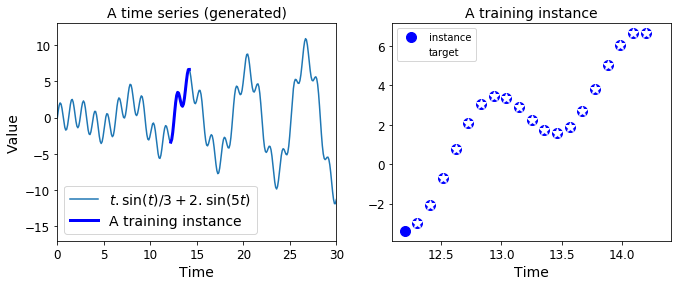

In [43]:
t = np.linspace(t_min,t_max,int((t_max-t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2,12.2+resolution * (n_steps +1) , n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t) , label=r"$t . \sin(t) / 3 +2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]),"b-",linewidth=3, label ="A training instance")
plt.legend(loc="lower left", fontsize = 14)
plt.axis([0,30,-17,13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize = 14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]),"bo", markersize=10,label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]),"w*",markersize=10,label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [48]:
X_batch , Y_batch = next_batch(1,n_steps)

In [51]:
np.c_[X_batch[0], y_batch[0]]

array([[-3.16457109,  8.03816824],
       [-4.16292195,  7.02290423],
       [-5.35199353,  5.84538455],
       [-6.49473915,  4.74877671],
       [-7.3533108 ,  3.94075692],
       [-7.74672286,  3.54312906],
       [-7.59471769,  3.56262725],
       [-6.93709904,  3.89004596],
       [-5.92380474,  4.32790384],
       [-4.77815246,  4.63986027],
       [-3.74225925,  4.60977619],
       [-3.01799873,  4.0959478 ],
       [-2.71795064,  3.06722281],
       [-2.83834981,  1.61214294],
       [-3.26065371, -0.08114022],
       [-3.7813397 , -1.76927426],
       [-4.16262985, -3.21158342],
       [-4.1917164 , -4.22726091],
       [-3.73397814, -4.73789088],
       [-2.76714814, -4.78490681]])

# Using an OutputProjectionWrapper

Let's create the RNN . It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each training instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequence of 20 inputs , each containing single value:

In [52]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32,[None, n_steps, n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation = tf.nn.relu)
outputs,states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At eah time step we have an output vector of size 100 . But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an OutputProjectionWrapper.

In [53]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32,[None, n_steps , n_inputs])
y = tf.placeholder(tf.float32,[None, n_steps, n_outputs])


In [54]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
       tf.contrib.rnn.BasicRNNCell(num_units = n_neurons, activation = tf.nn.relu),
       output_size = n_outputs)

In [55]:
outputs , states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

In [56]:
learning_rate = 0.001
loss = tf.reduce_mean(tf.square(outputs - y))# MSE
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [57]:
saver = tf.train.Saver()

In [59]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 18.9177
100 	MSE: 0.762551
200 	MSE: 0.290907
300 	MSE: 0.149525
400 	MSE: 0.0772763
500 	MSE: 0.0665644
600 	MSE: 0.0636215
700 	MSE: 0.0559812
800 	MSE: 0.0554487
900 	MSE: 0.0529518
1000 	MSE: 0.0534466
1100 	MSE: 0.051972
1200 	MSE: 0.0442769
1300 	MSE: 0.0547834
1400 	MSE: 0.0466028


In [60]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [61]:
y_pred

array([[[-3.42637658],
        [-2.46367216],
        [-1.15637207],
        [ 0.76617211],
        [ 2.29781222],
        [ 3.12525225],
        [ 3.4899745 ],
        [ 3.33646941],
        [ 2.82800984],
        [ 2.24254656],
        [ 1.71146703],
        [ 1.62021911],
        [ 2.00660276],
        [ 2.79940104],
        [ 3.91245008],
        [ 5.18602514],
        [ 6.16892099],
        [ 6.69519091],
        [ 6.66508675],
        [ 6.10952806]]], dtype=float32)

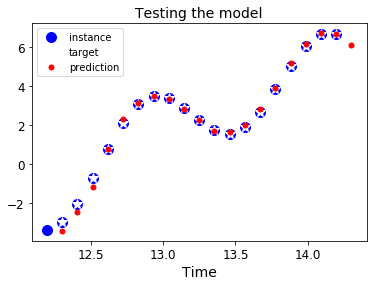

In [63]:

plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()